### Notas: Se puede optimizar ya que se está leyendo varias veces el mismo archivo csv

In [1]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Grouper
from pandas import DataFrame
import csv
import pickle
import math

In [2]:
def df_origen(origen,destino):     
    
    ######################PICKLE 21###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)

    df = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)    
    
    ######################PICKLE 2###############################
    with open('/home/jonathan/tesis/3er_avance/columns_names_confinamiento2.pickle', "rb") as file:   
        columns_names = pickle.load(file)

    names = list(columns_names)
    lista=["ds"]

    for trayectos in names:    
        x=trayectos.startswith(origen)    
        if x==True:                         
            lista.append(trayectos)
    
    df2 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=lista)
    
    #Filtramos el destino
    columns_names_df = df.columns   
    names_1 = list(columns_names_df)     
    
    listaDst=["ds"]
    for trayectos in names_1:            
        x=trayectos.split("-",1)[1]        
        if x==destino:                         
            listaDst.append(trayectos)
            
    df_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)    
    df2_Final = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=listaDst)

    
    #Cambiamos la frecuencia a dias
    df.index.freq = df.index.inferred_freq
    df_Dia = df.resample('24H').sum()
    
    df2.index.freq = df2.index.inferred_freq
    df2_Dia = df2.resample('24H').sum()

    #Sacamos una lista de los trayectos origen en comun con mayor número de viajes
    mean_df = df_Dia.mean()
    mean_dict = mean_df.to_dict()
    main_lines = list(dict.keys(dict(filter(lambda x: x[1] > 10000, mean_dict.items())))) #Obtengo las claves de las columnas con un promedio por dia mayor a 8000        
    
    mean_df2 = df2_Dia.mean()
    mean_dict2 = mean_df2.to_dict()
    main_lines2 = list(dict.keys(dict(filter(lambda x: x[1] > 9000, mean_dict2.items())))) #Obtengo las claves de las columnas con un promedio por dia mayor a 8000        
    
    #Sacamos solo los trayectos principales 
    main_lines.insert(0,"ds")    
    df_main_lines = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Referencia2.csv", sep=',',index_col=0, parse_dates=True, usecols=main_lines)
    
    main_lines2.insert(0,"ds")    
    df_main_lines2 = pd.read_csv("/home/jonathan/tesis/3er_avance/Trayectos_Periodo_Confinamiento2.csv", sep=',',index_col=0, parse_dates=True, usecols=main_lines2)
    
    #Añadimos nuevas columnas
    df_main_lines['Fecha'] = df_main_lines.index.date
    df_main_lines['Año'] = df_main_lines.index.year                                
    df_main_lines['Mes'] = df_main_lines.index.month                               
    df_main_lines['ID_Dia'] = df_main_lines.index.dayofweek
    df_main_lines['Hora'] = df_main_lines.index.hour
    
    df_main_lines2['Fecha'] = df_main_lines2.index.date
    df_main_lines2['Año'] = df_main_lines2.index.year                                
    df_main_lines2['Mes'] = df_main_lines2.index.month                               
    df_main_lines2['ID_Dia'] = df_main_lines2.index.dayofweek
    df_main_lines2['Hora'] = df_main_lines2.index.hour
    
    df_Final['Fecha'] = df_Final.index.date
    df_Final['Año'] = df_Final.index.year                                
    df_Final['Mes'] = df_Final.index.month                               
    df_Final['ID_Dia'] = df_Final.index.dayofweek
    df_Final['Hora'] = df_Final.index.hour
    df_Final['WeekNo'] = df_Final.index.isocalendar().week
    
    df2_Final['Fecha'] = df2_Final.index.date
    df2_Final['Año'] = df2_Final.index.year                                
    df2_Final['Mes'] = df2_Final.index.month                               
    df2_Final['ID_Dia'] = df2_Final.index.dayofweek
    df2_Final['Hora'] = df2_Final.index.hour
    df2_Final['WeekNo'] = df2_Final.index.isocalendar().week
    
    return df, lista, df_Dia, main_lines, df_main_lines, df2, df2_Dia, main_lines2, df_main_lines2, df_Final,df2_Final,listaDst

In [3]:
origen = "2807905"
destino = "2807901"
df,lista, df_Dia, main_lines, df_main_lines, df2, df2_Dia, main_lines2, df_main_lines2,df_Final,df2_Final,listaDst = df_origen(origen,destino)
df_main_lines.head(5)
df_main_lines2.head(5)
df_Final.head(5)
df2_Final.head(5)

,2807905-2807901,Fecha,Año,Mes,ID_Dia,Hora,WeekNo
ds,,,,,,,
2020-06-01 00:00:00,77.127,2020-06-01,2020,6,0,0,23
2020-06-01 01:00:00,32.415,2020-06-01,2020,6,0,1,23
2020-06-01 02:00:00,20.189,2020-06-01,2020,6,0,2,23
2020-06-01 03:00:00,46.381,2020-06-01,2020,6,0,3,23
2020-06-01 04:00:00,64.061,2020-06-01,2020,6,0,4,23


In [4]:
#Creamos intervalos de datos por periodos
data1=df_Final.loc['2020-02-14':'2020-03-15']
data2=df2_Final.loc['2020-06-01':'2020-06-30']
data3=df2_Final.loc['2020-07-01':'2020-07-31']
#data4=df2_Final.loc['2020-05-16':'2020-05-31']
#data4.tail(5)


In [5]:
##### Creamos tablas con cada uno de los principales trayectos
lista_periodos=[1,2,3]    
dict_dias={0:"Lunes",1:"Martes",2:"Miércoles",3:"Jueves",4:"Viernes",5:"Sábado",6:"Domingo"}
        
for periodo in lista_periodos:        
    cont=0
    globals()[f"d{periodo}"] = globals()[f"data{periodo}"].reset_index()                                
    globals()[f"df_{periodo}"] = pd.DataFrame(data=globals()[f"d{periodo}"], columns=[listaDst[1],'Hora','Fecha','WeekNo','ID_Dia'])
    globals()[f"df_{periodo}"].set_index([listaDst[1]], inplace = True) 
    
    for dia in dict_dias:        
        globals()[f"df_{dict_dias[dia]}_{periodo}"] = globals()[f"df_{periodo}"].loc[globals()[f"df_{periodo}"].loc[:,'ID_Dia'] == cont]  # Seleccionamos solo los datos del lunes o solo los datos del martes para crear nuevas tablas dependiendo del día        
        globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"] = pd.DataFrame({})  #Creamos un nuevo dataframe vacio
        globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].append(globals()[f"df_{dict_dias[dia]}_{periodo}"])  #Guardamos en el dataframe vacio cada una de las tablas, hay tabla lunes, tabla martes..
        
        #Seleccionamos celdas del dataframe para generar las fechas que se requieren graficar
        start = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].iloc[0]['Fecha'] #Primera celda de la columna fecha
        period_start = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].iloc[0]['WeekNo']
        period_end = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].at[globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].index[-1],'WeekNo']  #última celda de columna WeekNo
        
        #Condición de error en period_start/period_end
        if (type(period_start) == pd.core.series.Series) | (type(period_end) == pd.core.series.Series):    
            lista = list(period_end)
            period_end = lista[-1]        
        
        periods = list(range(period_start, period_end+1))

        #Obtenemos las fechas de cada día 
        date_generated = pd.date_range(start, periods=len(periods), freq='7D')
        
        #Creamos una tabla para cada fecha de cada lunes o de cada martes..
        cont2=1        
        for date in date_generated:            
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_{cont2}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].loc[globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].loc[:,'Fecha'] == date]
            cont2=cont2+1
        cont=cont+1   

/tmp/ipykernel_6556/91566757.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].append(globals()[f"df_{dict_dias[dia]}_{periodo}"])  #Guardamos en el dataframe vacio cada una de las tablas, hay tabla lunes, tabla martes..
/home/jonathan/anaconda3/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/tmp/ipykernel_6556/91566757.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  globals()[f"filtrado_D

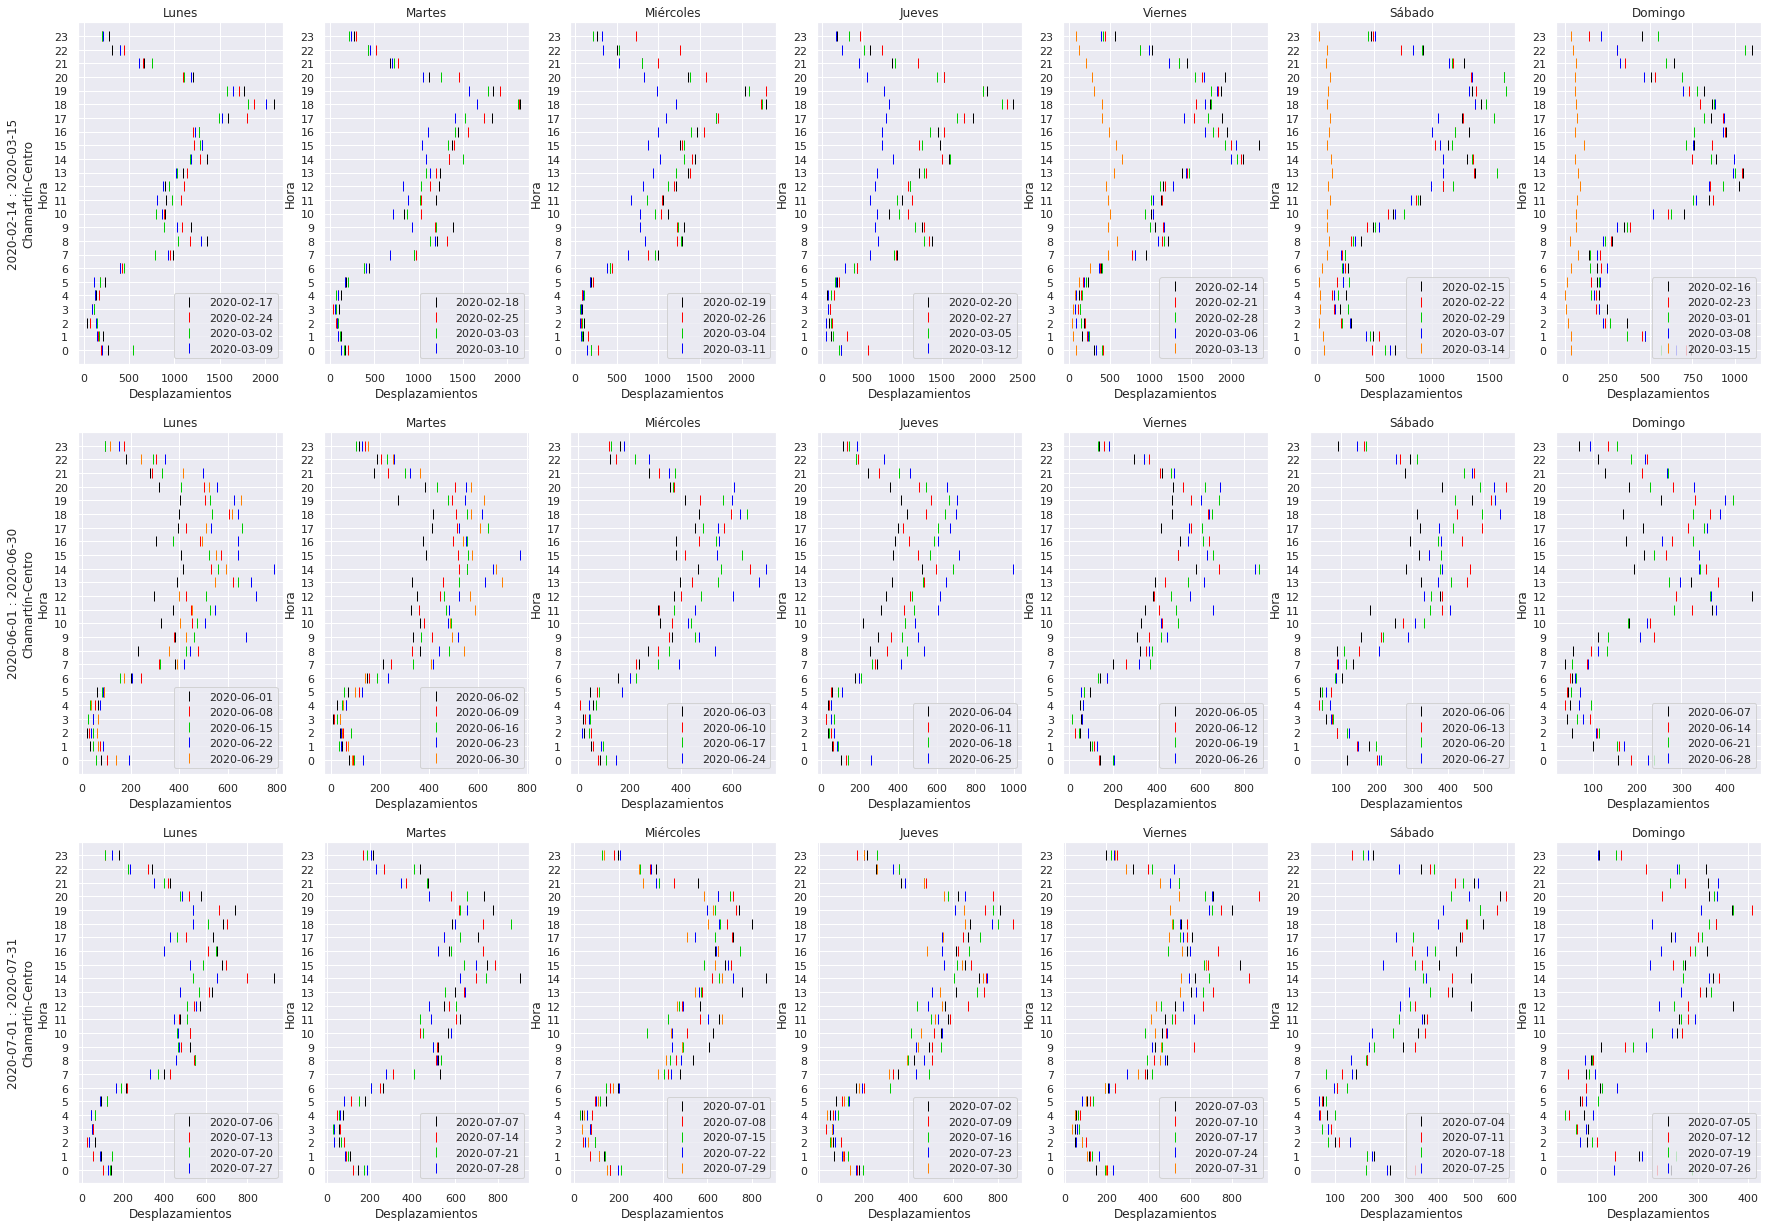

In [6]:
sb.set(rc = {'figure.figsize':(18,15)})
ax=0
Dict_periodos = {1:'2020-02-14 : 2020-03-15',2:'2020-06-01 : 2020-06-30', 3:'2020-07-01 : 2020-07-31'}

#Creamos dicionario para buscar el nombre de cada distrito
for line in listaDst:    
    if line=="ds":        
        fig, axes = plt.subplots(nrows=3, ncols=7)
        ax_list = fig.axes
        plt.subplots_adjust(left=0.001, bottom=None, right=1.3, top=1.2, wspace=0.2, hspace=0.2)
        continue
        
    origen = line.split("-",1)[0]
    destino = line.split("-",1)[1]    
    lines_names = {"19024":"Fuera_Madrid","2800601":"Fuera_Madrid","2806504":"Fuera_Madrid","2807901":"Centro","2807902":"Arganzuela","2807903":"Retiro","2807904":"Salamanca","2807905":"Chamartín","2807906":"Tetuán","2807907":"Chamberí","2807908":"El_Pardo","2807909":"Moncloa-Aravaca","2807910":"Latina","2807911":"Carabanchel","2807912":"Usera","2807913":"Puente_de_Vallecas","2807914":"Moratalaz","2807915":"Ciudad_Lineal","2807916":"Hortaleza","2807917":"Villaverde","2807918":"Villa_de_Vallecas","2807919":"Vicálvaro","2807920":"San Blas-Canillejas","2812301":"Fuera_Madrid"}
    
for periodo in lista_periodos:    
    
    for dia in dict_dias:
        
        #Seleccionamos celdas del dataframe para generar las fechas que se requieren graficar
        start = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].iloc[0]['Fecha'] #Primera celda de la columna fecha
        period_start = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].iloc[0]['WeekNo']
        period_end = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].at[globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}"].index[-1],'WeekNo']  #última celda de columna WeekNo
        
        #Condición de error en period_start/period_end
        if (type(period_start) == pd.core.series.Series) | (type(period_end) == pd.core.series.Series):    
            lista = list(period_end)
            period_end = lista[-1]        
        
        periods = list(range(period_start, period_end+1))

        #Obtenemos las fechas de cada día 
        date_generated = pd.date_range(start, periods=len(periods), freq='7D')        
        
        cont2=1  
        for date in date_generated:    
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_{cont2}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_{cont2}"].iloc[:,0:1]        
            cont2=cont2+1
        if cont2==2:
            globals()[f"p{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_1"].plot(marker='|', markersize=10,linestyle='none',color='black',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])            
            globals()[f"p{dict_dias[dia]}_{periodo}"].legend([date_generated[0].strftime('%Y-%m-%d')], loc="lower right")
        if cont2==3:
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_1"].plot(marker='|', markersize=10,linestyle='none',color='black',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"p{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_2"].plot(marker='|', markersize=10,linestyle='none',color='red',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])            
            globals()[f"p{dict_dias[dia]}_{periodo}"].legend([date_generated[0].strftime('%Y-%m-%d'),date_generated[1].strftime('%Y-%m-%d')], loc="lower right")
        if cont2==4:
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_1"].plot(marker='|', markersize=10,linestyle='none',color='black',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_2"].plot(marker='|', markersize=10,linestyle='none',color='red',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"p{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_3"].plot(marker='|', markersize=10,linestyle='none',color='#00CC00',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])#Verde            
            globals()[f"p{dict_dias[dia]}_{periodo}"].legend([date_generated[0].strftime('%Y-%m-%d'),date_generated[1].strftime('%Y-%m-%d'),date_generated[2].strftime('%Y-%m-%d')], loc="lower right")
        if cont2==5:
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_1"].plot(marker='|', markersize=10,linestyle='none',color='black',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_2"].plot(marker='|', markersize=10,linestyle='none',color='red',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_3"].plot(marker='|', markersize=10,linestyle='none',color='#00CC00', ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])#Verde
            globals()[f"p{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_4"].plot(marker='|', markersize=10,linestyle='none',color='blue',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])                        
            globals()[f"p{dict_dias[dia]}_{periodo}"].legend([date_generated[0].strftime('%Y-%m-%d'),date_generated[1].strftime('%Y-%m-%d'),date_generated[2].strftime('%Y-%m-%d'),date_generated[3].strftime('%Y-%m-%d')], loc="lower right")
        if cont2==6:
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_1"].plot(marker='|', markersize=10,linestyle='none',color='black',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_2"].plot(marker='|', markersize=10,linestyle='none',color='red',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_3"].plot(marker='|', markersize=10,linestyle='none',color='#00CC00',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])#Verde
            globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_4"].plot(marker='|', markersize=10,linestyle='none',color='blue',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])# Azul claro #6495ED
            globals()[f"p{dict_dias[dia]}_{periodo}"] = globals()[f"filtrado_Data_{dict_dias[dia]}_{periodo}_5"].plot(marker='|', markersize=10,linestyle='none',color='#FF8000',ax=ax_list[ax]); ax_list[ax].set_title(dict_dias[dia])#Naranja        
            globals()[f"p{dict_dias[dia]}_{periodo}"].legend([date_generated[0].strftime('%Y-%m-%d'),date_generated[1].strftime('%Y-%m-%d'),date_generated[2].strftime('%Y-%m-%d'),date_generated[3].strftime('%Y-%m-%d'),date_generated[4].strftime('%Y-%m-%d')], loc="lower right")
            
        
        globals()[f"p{dict_dias[dia]}_{periodo}"].yaxis.set_ticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])                            #Fijamos los ticks blancos para cada hora
        if (ax==0)|(ax==7)|(ax==14)|(ax==21):        
            globals()[f"p{dict_dias[dia]}_{periodo}"].set_ylabel(Dict_periodos[periodo]+"\n"+lines_names[origen]+"-"+lines_names[destino]+"\n"+"Hora")    #Título del periodo a la izquierda y trayecto          
        else:
            globals()[f"p{dict_dias[dia]}_{periodo}"].set_ylabel("Hora")  
        globals()[f"p{dict_dias[dia]}_{periodo}"].set_xlabel("Desplazamientos")          
        globals()[f"p{dict_dias[dia]}_{periodo}"].set_ylim(-1, 24)       
        ax=ax+1        
